In [33]:
import pandas as pd
#import os
import csodiaq_base_functions as cbf
import csodiaq_menu_functions as menu
#import re
from collections import defaultdict
#import statistics
#import csv
#from matplotlib_venn import venn3
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
import numpy as np
#from matplotlib.ticker import PercentFormatter
#import math
#from scipy.stats import linregress
import pickle
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statistics

def set_plot_settings(xlabel, ylabel, wide=True):
    if wide: plt.figure(figsize=(18,12))
    else: plt.figure(figsize=(12,12))
    #plt.axhline(linewidth=4, y=1, color='black')
    #plt.axhline(linewidth=4, y=10, color='black')
    #plt.axvline(linewidth=4, x=1.5, color='black')
    #plt.axvline(linewidth=4, x=10, color='black')
    #plt.xlabel(xlabel, fontsize = 36, weight='bold')
    #plt.ylabel(ylabel, fontsize = 36, weight='bold')
    plt.tick_params(axis="x", labelsize=18)
    plt.tick_params(axis="y", labelsize=18)
    
def set_plot_settings2(xlabel, ylabel, wide=True):
    if wide: plt.figure(figsize=(6,4))
    else: plt.figure(figsize=(12,12))
    #plt.axhline(linewidth=4, y=1, color='black')
    #plt.axhline(linewidth=4, y=10, color='black')
    #plt.axvline(linewidth=4, x=1.5, color='black')
    #plt.axvline(linewidth=4, x=10, color='black')
    plt.xlabel(xlabel, fontsize = 18, weight='bold')
    plt.ylabel(ylabel, fontsize = 18, weight='bold')
    plt.tick_params(axis="x", labelsize=18)
    plt.tick_params(axis="y", labelsize=18)

In [9]:
def calc_key_variables(df, r, type, ori=1):
    if ori:
        if type=='LC': col = 'Ratio H/L 1to'+str(r)
        else: col = 'Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to'+str(r)+'_01.mzXML'
        ratio = r
    else:
        if type=='LC': col = 'Ratio H/L '+str(r)+'to1'
        else: col = 'Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_'+str(r)+'to1_01.mzXML'
        ratio = -r
    if r==1: ratio=0


    if type=='LC': df[col] = np.log2(df[col])
    app = df[~df[col].isnull()][col]
    if len(app) > 0: return [[np.median(app),statistics.pstdev(app),ratio, type, len(app)]]

    return [[0,0, ratio, type, 0]]

def calc_all_variables(df, type, ratios):
    data = []
    for ratio in ratios:
        data += calc_key_variables(df, ratio, type)
        if ratio != 1: data += calc_key_variables(df, ratio, type, ori=0)
    finalDf = pd.DataFrame(data, columns=['median','stdev','ratio','type', 'numPeps'])
    finalDf = finalDf.sort_values('ratio', ascending=False).reset_index(drop=True)
    return finalDf

## UMAPs

In [10]:
head = 'C:/Users/ccranney/Desktop/Caleb_Files/csoDIAq/figure5_quantification/variables/'

# Finding best variables
allVariables = pd.read_csv(head + 'full_compare_noSqrRt_HalvingBot10_mgf.csv')
#allVariables = pd.read_csv('Data/QuantifyCompare/variables/full_compare_noSqrRt_HalvingBot10_traml.csv')
print('no filter:')
print(len(allVariables))
print('\n')

# filter by average standard deviation
allVariables = allVariables[allVariables['avrStDev'] < 1]
print('filter out average standard deviations above 1:')
print(len(allVariables))
print('\n')

# filter by number of peptides
allVariables = allVariables[allVariables['numPeps'] > (3864*.8)]
#allVariables = allVariables[allVariables['numPeps'] > (2926*.75)]
print('filter out peptides < 75%:')
print(len(allVariables))
print('\n')

# filter slopes not close to 1
allVariables = allVariables[(allVariables['slope'] > .95) & (allVariables['slope'] < 1.05)]
print('filter out slopes outside .5 from 1:')
print(len(allVariables))
print('\n')

print(allVariables)
topHits = allVariables.index

# UMAP attempt
allVariables = pd.read_csv(head + 'full_compare_noSqrRt_HalvingBot10_mgf.csv')
#t1 = ['one stdev' if x=='1' else x for x in allVariables['corrStDev']]
#allVariables['corrStDev'] = t1
#print(t1)
#allVariables.to_csv('Data/QuantifyCompare/variables/full_compare_noSqrRt_HalvingBot10_mgf.csv', index=False)
allVariables = allVariables[(allVariables['mode']=='mean') | (allVariables['mode']=='median')]#.reset_index(drop=True)
#topHits = [101, 133, 149, 181, 213, 229]



reducer = umap.UMAP()
print(1)
data = allVariables[
    ['slope',
#    'intercept',
#    'rvalue',
#    'pvalue',
#    'stderr',
    'avrStDev',
    'numPeps']
].values
scaled_data = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled_data)

#continue UMAP
x_values = embedding[:, 0]
y_values = embedding[:, 1]
#pickle.dump(x_values, open( "Data/x.p", "wb" ))
#pickle.dump(y_values, open( "Data/y.p", "wb" ))
x_values = pickle.load(open( head + "x.p", "rb" ))
y_values = pickle.load(open( head + "y.p", "rb" ))

ins = ['numPeps','avrStDev','slope']
outs = ['corrStDev','libPeaks','minMatch']
edgeColors = ['#DC143C' if x in topHits else 'white' for x in allVariables.index]
edgeWidth = [6 if x in topHits else 0.5 for x in allVariables.index]
palDict = {
    'avrStDev':'viridis',
    'numPeps':'viridis_r',
    'slope':'viridis_r'
    #'numPeps':'Purples',
    #'slope':'YlOrBr'
}

no filter:
256


filter out average standard deviations above 1:
69


filter out peptides < 75%:
42


filter out slopes outside .5 from 1:
6


    libPeaks minMatch    mode corrStDev     slope  intercept    rvalue  \
101       10   custom  median    custom  0.964265   0.092953  0.997231   
133       10        2  median    custom  0.961745   0.095426  0.997226   
149       10        3  median    custom  0.968484   0.098526  0.997694   
181      all   custom  median    custom  0.963690   0.092613  0.997219   
213      all        2  median    custom  0.961380   0.095479  0.997235   
229      all        3  median    custom  0.967647   0.097718  0.997615   

           pvalue    stderr  avrStDev  numPeps  
101  7.735264e-07  0.032156  0.985437     3489  
133  7.773221e-07  0.032104  0.966362     3416  
149  4.897264e-07  0.029463  0.946932     3139  
181  7.823180e-07  0.032210  0.984965     3489  
213  7.706554e-07  0.032036  0.968200     3419  
229  5.328438e-07  0.029941  0.946539     31

In [11]:
for i in ins:
    print(i)
    for o in outs:

        labels = allVariables[i]
        markers = allVariables[o]
        #print(len(allVariables))
        #sns.set_palette("viridis")
        h = None
        if i=='slope': h = (None, 1)


        set_plot_settings('','')
        #style=markers,
        ax = sns.scatterplot(x=x_values, y=y_values, hue=labels, palette=palDict[i], edgecolor=edgeColors, hue_norm=h, s=750, linewidth=edgeWidth)
        norm = plt.Normalize(allVariables[i].min(), allVariables[i].max())
        sm = plt.cm.ScalarMappable(cmap=palDict[i], norm=norm)
        sm.set_array([])

        ax.get_legend().remove()
        cbar = ax.figure.colorbar(sm)
        cbar.ax.tick_params(labelsize=48)
        pyplot.xlim(0.1,10)
        pyplot.ylim(0.1,10)
        pyplot.yticks(np.arange(2,11,2), fontsize=48)
        pyplot.xticks(np.arange(2,11,2), fontsize=48)

        #plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area')
        #plt.show()
        plt.savefig(head+i+o+'.png')
        plt.savefig(head+i+o+'.svg')
        plt.close("all")

numPeps
avrStDev
slope


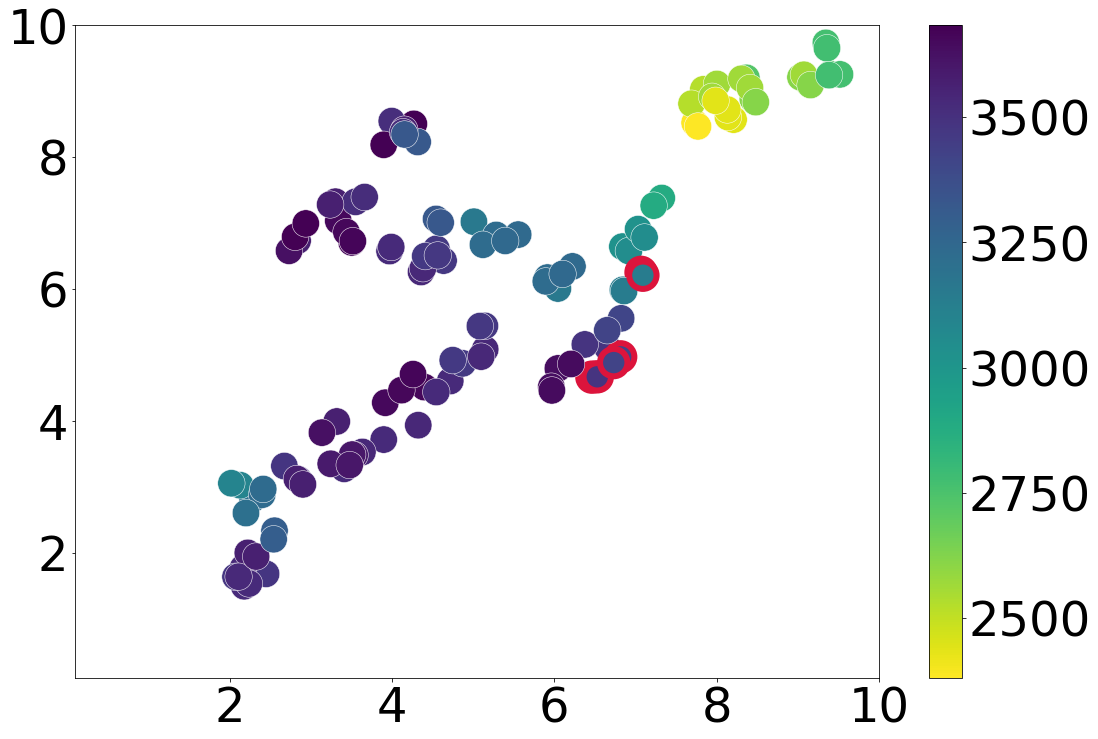

In [12]:
i = 'numPeps'
labels = allVariables[i]
#markers = allVariables[o]
#print(len(allVariables))
#sns.set_palette("viridis")
h = None
if i=='slope': h = (None, 1)


set_plot_settings('','')
#style=markers,
ax = sns.scatterplot(x=x_values, y=y_values, hue=labels, palette=palDict[i], edgecolor=edgeColors, hue_norm=h, s=750, linewidth=edgeWidth)
norm = plt.Normalize(allVariables[i].min(), allVariables[i].max())
sm = plt.cm.ScalarMappable(cmap=palDict[i], norm=norm)
sm.set_array([])

ax.get_legend().remove()
cbar = ax.figure.colorbar(sm)
cbar.ax.tick_params(labelsize=48)
pyplot.xlim(0.1,10)
pyplot.ylim(0.1,10)
pyplot.yticks(np.arange(2,11,2), fontsize=48)
pyplot.xticks(np.arange(2,11,2), fontsize=48)

#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area')
plt.savefig(head+i+'.png')
plt.savefig(head+i+'.svg')

plt.show()


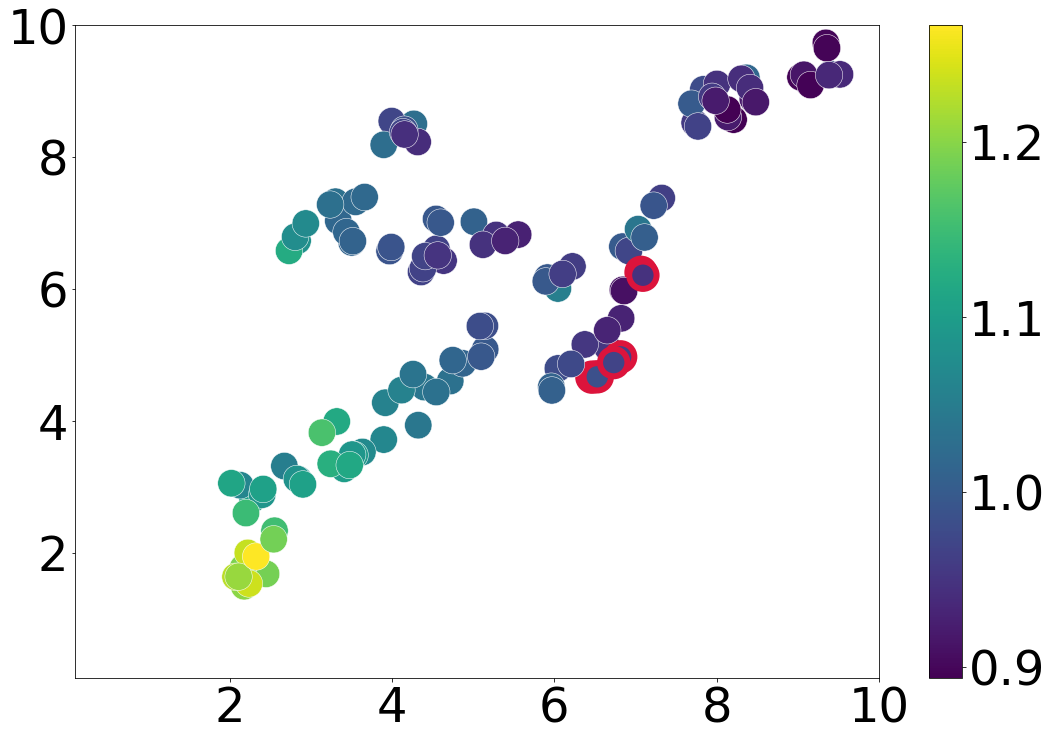

In [13]:
i = 'avrStDev'
labels = allVariables[i]
#markers = allVariables[o]
#print(len(allVariables))
#sns.set_palette("viridis")
h = None
if i=='slope': h = (None, 1)


set_plot_settings('','')
#style=markers,
ax = sns.scatterplot(x=x_values, y=y_values, hue=labels, palette=palDict[i], edgecolor=edgeColors, hue_norm=h, s=750, linewidth=edgeWidth)
norm = plt.Normalize(allVariables[i].min(), allVariables[i].max())
sm = plt.cm.ScalarMappable(cmap=palDict[i], norm=norm)
sm.set_array([])

ax.get_legend().remove()
cbar = ax.figure.colorbar(sm)
cbar.ax.tick_params(labelsize=48)
pyplot.xlim(0.1,10)
pyplot.ylim(0.1,10)
pyplot.yticks(np.arange(2,11,2), fontsize=48)
pyplot.xticks(np.arange(2,11,2), fontsize=48)

#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area')
plt.savefig(head+i+'.png')
plt.savefig(head+i+'.svg')

plt.show()


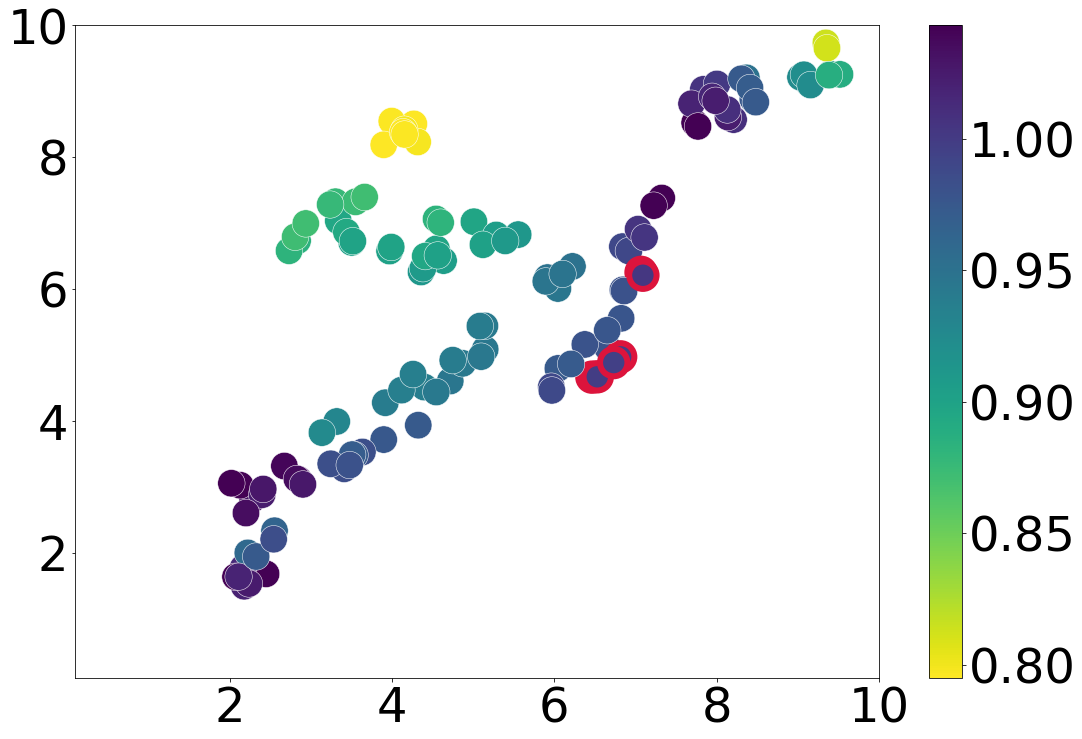

In [14]:
i = 'slope'
labels = allVariables[i]
#markers = allVariables[o]
#print(len(allVariables))
#sns.set_palette("viridis")
h = None
if i=='slope': h = (None, 1)


set_plot_settings('','')
#style=markers,
ax = sns.scatterplot(x=x_values, y=y_values, hue=labels, palette=palDict[i], edgecolor=edgeColors, hue_norm=h, s=750, linewidth=edgeWidth)
norm = plt.Normalize(allVariables[i].min(), allVariables[i].max())
sm = plt.cm.ScalarMappable(cmap=palDict[i], norm=norm)
sm.set_array([])

ax.get_legend().remove()
cbar = ax.figure.colorbar(sm)
cbar.ax.tick_params(labelsize=48)
pyplot.xlim(0.1,10)
pyplot.ylim(0.1,10)
pyplot.yticks(np.arange(2,11,2), fontsize=48)
pyplot.xticks(np.arange(2,11,2), fontsize=48)

#plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='City Area')
plt.savefig(head+i+'.png')
plt.savefig(head+i+'.svg')

plt.show()


## BoxPlots

In [28]:
head = 'C:/Users/ccranney/Desktop/Caleb_Files/csoDIAq/figure5_quantification/'

dfLC = pd.read_csv(head + 'MQpeptides_Quant.csv')
dfPepsDIA = pd.read_csv(head + 'mostintense_quantmzlist.txt', sep='\t')
dfDIACaleb = pd.read_csv(head + 'CalebOutput2.csv')

LCSet = set(dfLC['Sequence'])

DIASet = set(dfPepsDIA['Peptide'])

DIASet2 = dfDIACaleb['peptide']

both = set.intersection(LCSet, DIASet)
both = set.intersection(both, DIASet2)

print(len(both))
print(both)

dfLC = dfLC.loc[dfLC['Sequence'].isin(both)]
dfDIACaleb = dfDIACaleb.loc[dfDIACaleb['peptide'].isin(both)]
dfPepsDIA = dfPepsDIA.loc[dfPepsDIA['Peptide'].isin(both)]
ScanListDIA = [row['scan'] for index, row in dfPepsDIA.iterrows()]
print(ScanListDIA)


ratios = [1, 2, 4, 8]

lc = calc_all_variables(dfLC, 'LC', ratios)
X = lc['median']

lcCols = [
    'Ratio H/L 1to8',
    'Ratio H/L 1to4',
    'Ratio H/L 1to2',
    'Ratio H/L 1to1',
    'Ratio H/L 2to1',
    'Ratio H/L 4to1',
    'Ratio H/L 8to1',
]

ratioStr = [
    '1:8',
    '1:4',
    '1:2',
    '1:1',
    '2:1',
    '4:1',
    '8:1',
]

266
{'FPLTTESAMK', 'VPSLVGSFIR', 'IANPVEGSSGR', 'ITMIAEPLEK', 'VVDALGNAIDGK', 'HLQLAVRNDEELNK', 'IDVGEAEPR', 'MFGGPGTASRPSSSR', 'MPLIGLGTWK', 'TAVVVGTITDDVRVQEVPK', 'TPYTIMFGPDK', 'EIGNIISDAMK', 'NIEDVIAQGIGK', 'DLPEHAVLK', 'ENLSYDLVPLK', 'LLLLAGVDRLDK', 'DRSSFYVNGLTLGGQK', 'GTVEPQLEAR', 'EAPPMEKPEVVK', 'FAFQAEVNR', 'TPVEPEVAIHR', 'AALLWALAAALER', 'DFLAGGIAAAISK', 'TALIHDGLAR', 'LNNLVLFDK', 'AGIVTSLQAR', 'YALYDASFETK', 'IALTDNALIAR', 'VLTPEEQLADK', 'MSVQPTVSLGGFEITPPVVLR', 'STFVLDEFK', 'VADIGLAAWGR', 'AAGVNVEPFWPGLFAK', 'IIGNLLYYR', 'DLLHPSPEEEK', 'VLTVINQTQK', 'RHLTGEFEK', 'IGIVGLPNVGK', 'EAVAMESYAK', 'VAQLEQVYIR', 'VVFVFGPDK', 'NSLPDTVQIR', 'AVPEGFVIPR', 'SINPDEAVAYGAAVQAAILSGDK', 'GGIVDEGALLR', 'IREYFGEFGEIEAIELPMDPK', 'VVDLLAPYAK', 'ISDSEGFK', 'ISVYYNEATGGK', 'NLIDAGVDALR', 'GLGTDDNTLIR', 'VAFTGSTEVGK', 'AVENYLIQMAR', 'KPLTSSSAAPQRPISTQR', 'AQVARPGGDTIFGK', 'MGPLGLDHMASSIER', 'TVATPLNQVANPNSAIFGGARPREEVVQK', 'VLLPEYGGTK', 'HWGGNVLGPK', 'ETEGDVTSVK', 'DHASIQMNVAEVDK', 'EKPTTALLDK', 

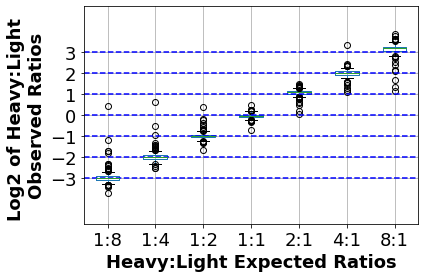

In [37]:
boxLC = dfLC.loc[:, dfLC.columns.intersection(lcCols)]
boxLC = boxLC[lcCols]
boxLC.columns = ratioStr

set_plot_settings2('Heavy:Light Expected Ratios','Log2 of Heavy:Light \nObserved Ratios')
boxLC.boxplot(column=ratioStr)
plt.axhline(y=-3, color='blue', linestyle='dashed')
plt.axhline(y=-2, color='blue', linestyle='dashed')
plt.axhline(y=-1, color='blue', linestyle='dashed')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.axhline(y=1, color='blue', linestyle='dashed')
plt.axhline(y=2, color='blue', linestyle='dashed')
plt.axhline(y=3, color='blue', linestyle='dashed')
plt.ylim(-5.2, 5.2)
pyplot.yticks(np.arange(-3,4))
plt.savefig(head+'5_D.png', bbox_inches='tight')
plt.savefig(head+'5_D.svg', bbox_inches='tight')


plt.show()

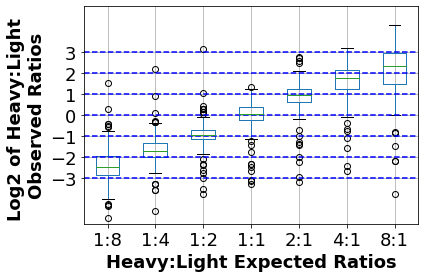

In [38]:
finalDf = pd.read_csv(head + 'jesseOutput.csv')
finalDf.columns = ['scan'] + ratioStr
finalDf = finalDf[finalDf['scan'].isin(ScanListDIA)]
set_plot_settings2('Heavy:Light Expected Ratios','Log2 of Heavy:Light \nObserved Ratios')
finalDf.boxplot(column=ratioStr)
plt.axhline(y=-3, color='blue', linestyle='dashed')
plt.axhline(y=-2, color='blue', linestyle='dashed')
plt.axhline(y=-1, color='blue', linestyle='dashed')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.axhline(y=1, color='blue', linestyle='dashed')
plt.axhline(y=2, color='blue', linestyle='dashed')
plt.axhline(y=3, color='blue', linestyle='dashed')
plt.ylim(-5.2, 5.2)
pyplot.yticks(np.arange(-3,4))
plt.savefig(head+'5_E.png', bbox_inches='tight')
plt.savefig(head+'5_E.svg', bbox_inches='tight')

plt.show()

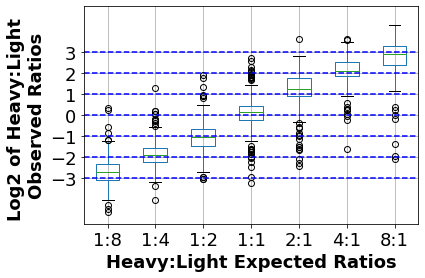

In [39]:
dfDIACaleb.columns = ['peptide','scan'] + ratioStr
set_plot_settings2('Heavy:Light Expected Ratios','Log2 of Heavy:Light \nObserved Ratios')
dfDIACaleb.boxplot(column=ratioStr)
plt.axhline(y=-3, color='blue', linestyle='dashed')
plt.axhline(y=-2, color='blue', linestyle='dashed')
plt.axhline(y=-1, color='blue', linestyle='dashed')
plt.axhline(y=0, color='blue', linestyle='dashed')
plt.axhline(y=1, color='blue', linestyle='dashed')
plt.axhline(y=2, color='blue', linestyle='dashed')
plt.axhline(y=3, color='blue', linestyle='dashed')
plt.ylim(-5.2, 5.2)
pyplot.yticks(np.arange(-3,4))
plt.savefig(head+'5_F.png', bbox_inches='tight')
plt.savefig(head+'5_F.svg', bbox_inches='tight')

plt.show()